In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numba import jit

from velocity_models import *
from seismic_wavelets import ricker_wavelet

In [2]:
h = 10.0                                       # espaçamento da malha
dt = 0.0005                                    # taxa de variação temporal
dimX = 300                                     # extensão do domínio
dimZ = 200                                     # profundidade do domínio
Ntotal = 2000                                  # tempo total discreto
cut_frequency = 30                             # frequencia de corte


# posicionamento fonte sísmica
shot_x = 150
shot_z = 5
# posicionamento receptores
numberOfReceivers = 100
rec_x = range(shot_x - int(numberOfReceivers/2), shot_x + int(numberOfReceivers/2))
rec_z = 5        

In [3]:
seismic_source       = np.zeros(Ntotal)            # fonte sísmica
velocity             = np.zeros((dimZ, dimX))      # campo de velocidades
C                    = np.zeros((dimZ, dimX))      # matriz auxilar
    
wavefield01          = np.zeros((dimZ, dimX))      # campo de pressão em n - dt
wavefield02          = np.zeros((dimZ, dimX))      # campo de pressão em n
wavefield03          = np.zeros((dimZ, dimX))      # campo de pressão em n + dt

seismogram           = np.zeros((Ntotal, numberOfReceivers))    # sismograma

In [4]:
# definindo campo de velocidades
#velocity = constant_velocity(1500.0, dimX, dimZ)
vel_layers = [1500.0, 2000.0]
velocity = parallel_layers(vel_layers, dimX, dimZ)

# definindo a fonte sismica (ricker)
seismic_source = ricker_wavelet(cut_frequency, dt, Ntotal)

In [5]:
# coeficiente de diferencas finitas
c = (-5.0/2.0, 4.0/3.0, -1.0/12.0)

# matriz auxiliar Cik
for i in range(dimZ):
    for k in range(dimX):
        C[i, k] = (velocity[i, k] * (dt/h)) ** 2

In [6]:
@jit
def wave_equation(wavefield01, wavefield02, wavefield03, C, c):
    for i in range(2, dimZ-2):
            for k in range(2, dimX-2):

                wavefield03[i,k] = C[i,k] * (2.0*c[0]*wavefield02[i, k] + 
                                             c[1]*(wavefield02[i,k-1] + wavefield02[i,k+1] + 
                                                   wavefield02[i-1,k] + wavefield02[i+1,k]) +
                                             c[2]*(wavefield02[i,k-2] + wavefield02[i,k+2] + 
                                                   wavefield02[i-2,k] + wavefield02[i+2,k])) + 2.0*wavefield02[i,k] - wavefield01[i,k]

/tmp/ipykernel_19056/4137363106.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def wave_equation(wavefield01, wavefield02, wavefield03, C, c):


In [7]:
def seismic_modeling(wavefield01, wavefield02, wavefield03, 
                     C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismogram):
    
    for n in range(0, Ntotal):

        # Cálculo do Campo no interior do modelo
        wave_equation(wavefield01, wavefield02, wavefield03, C, c)

        # Termo fonte
        wavefield02[shot_z,shot_x] = wavefield02[shot_z,shot_x] + seismic_source[n]*(velocity[shot_z,shot_x]**2)
        
        for irec in range(len(rec_x)):
            seismogram[n, irec] = wavefield03[rec_z, rec_x[irec]]
            
            
        # Atualização do campo de onda
        wavefield01 = np.copy(wavefield02)
        wavefield02 = np.copy(wavefield03)

        if n % 1000 == 0:
            print(n)

In [8]:
seismic_modeling(wavefield01, wavefield02, wavefield03, 
                                  C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismogram)

0
1000


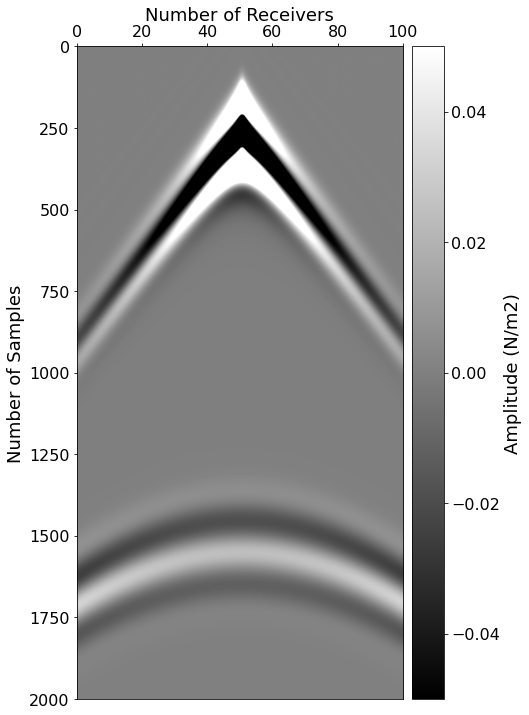

In [9]:
from data_plotting import plotting_seismogram

image_name = "seismogram.png"

plotting_seismogram(Ntotal, numberOfReceivers, seismogram, image_name)